<center><h1>Evaluation of the MLM models</h1></center>

## Import librairies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet as wn
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import tensorflow as tf
from transformers import TFAutoModelForMaskedLM, AutoTokenizer

## Import Datasets

In [ ]:
df_bert = pd.read_excel("../../Datasets/bert-base-uncased.xlsx")
df_roberta = pd.read_excel("../../Datasets/roberta-base_pred.xlsx")
df_distilroberta = pd.read_excel("../../Datasets/distilroberta-base_pred.xlsx")
df_albert = pd.read_excel("../../Datasets/albert-base_pred.xlsx")
df_ditilbert = pd.read_excel("../../Datasets/distilbert-base-uncased_pred_ngram.xlsx")

## Evaluation function

### Accuracy

In [ ]:
def remove_all(liste, value):
    while value in liste:
        liste.remove(value)
    return liste

def similarity(word, list_of_words):
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Get the synsets of the word
    synsets_word = wn.synsets(lemmatizer.lemmatize(word))

    # Calculate the similarity between the word and each word in the list
    similarities = []
    for w in list_of_words:
        synsets_w = wn.synsets(lemmatizer.lemmatize(w))
        max_sim = 0
        for synset_word in synsets_word:
            for synset_w in synsets_w:
                sim = synset_word.path_similarity(synset_w)
                if sim is not None and sim > max_sim:
                    max_sim = sim
        similarities.append(max_sim)

    if word in list_of_words:
        similarities.append(1)

    # Print the list of similarities
    return np.max(similarities)

### Pseudo-log-likelihood (PLL) and Perplexity

#### Explanation :

##### PLL

Pseudo-log-likelihood (PLL) is a scoring method used in language modeling, taken from the pdf here : https://aclanthology.org/2020.acl-main.240.pdf. 

It calculates the probability of a word given its previous words in a sentence, by treating the remaining words as a set of distractors.


The PLL score is calculated as follows:
1.
For each word w in the sentence, PLL computes its log probability given the preceding words. This is done by taking the sum of the log probabilities of the word w given each of the preceding words in the sentence.
2.
The PLL score is then computed as the sum of these log probabilities, divided by the number of words in the sentence minus 1. The minus 1 is used to exclude the last word in the sentence, which has no succeeding words.


//
Lower PLL values indicate that the model assigns higher probabilities to the true tokens in the input text, which means that the model is better at predicting the masked tokens.

##### Perplexity 

Perplexity is a measure of how well a probability distribution or model predicts a sample. 
It is calculated as the exponential of the cross-entropy loss between the predicted token probabilities and the true tokens. 


//
Lower perplexity values indicate that the model assigns higher probabilities to the true tokens in the input text, which means that the model is better at predicting the next token in a sequence.

##  A pytorch version

In [1]:
# Define a function to calculate the Pseudo-log-likelihood (PLL) score for a given language model, tokenizer, and input text
def calculate_pll(model, tokenizer, text):
    # Tokenize the input text
    input_ids = tokenizer.encode(text, return_tensors='pt')
    # Run the model on the input text without calculating gradients
    with torch.no_grad():
        outputs = model(input_ids)
        predictions = outputs[0]
    # Define the loss function as cross-entropy loss
    loss = torch.nn.CrossEntropyLoss()
    # Initialize PLL to 0
    pll = 0
    # Iterate over each token in the input text
    for i in range(len(input_ids[0])):
        # Create a copy of the input ids and mask the current token
        masked_input_ids = input_ids.clone()
        masked_input_ids[0][i] = tokenizer.mask_token_id
        # Run the model on the masked input text without calculating gradients
        with torch.no_grad():
            outputs = model(masked_input_ids)
            predictions = outputs[0]
        # Calculate the cross-entropy loss between the predicted token probabilities and the true token and add it to PLL
        pll += loss(predictions[0][i].unsqueeze(0), input_ids[0][i].unsqueeze(0)).item()
    # Return the calculated PLL value
    return pll

In [2]:
# Define a function to calculate the perplexity for a given language model, tokenizer, and input text
def calculate_perplexity(model, tokenizer, text):
    # Tokenize the input text
    input_ids = tokenizer.encode(text, return_tensors='pt')
    # Run the model on the input text with labels and without calculating gradients
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    # Calculate and return the perplexity as the exponential of the cross-entropy loss
    return torch.exp(loss).item()

In [3]:
# Example usage:
# Define the name of the pre-trained language model to use
model_name = 'bert-base-uncased'
# Load the tokenizer associated with the pre-trained language model
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Load the pre-trained language model for masked language modeling
model = AutoModelForMaskedLM.from_pretrained(model_name)

# Define an example input text
text = "I love my video Games"
# Calculate PLL and perplexity for the given language model, tokenizer, and input text using the defined functions
pll = calculate_pll(model, tokenizer, text)
perplexity = calculate_perplexity(model, tokenizer, text)

# Print out the calculated PLL and perplexity values
print(f'PLL: {pll}')
print(f'Perplexity: {perplexity}')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

c:\Users\Rania\anaconda3\envs\mybase\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Rania\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PLL: 82.82536670565605
Perplexity: 87.86251831054688


## A tf version

In [4]:
# Define a function to calculate the Pseudo-log-likelihood (PLL) score for a given language model, tokenizer, and input text
def calculate_pll(model, tokenizer, text):
    # Tokenize the input text
    input_ids = tokenizer.encode(text, return_tensors='tf')
    # Run the model on the input text
    outputs = model(input_ids)
    predictions = outputs[0]
    # Define the loss function as sparse categorical cross-entropy loss
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # Initialize PLL to 0
    pll = 0
    # Iterate over each token in the input text
    for i in range(len(input_ids[0])):
        # Create a copy of the input ids and mask the current token
        masked_input_ids = input_ids.numpy().copy()
        masked_input_ids[0][i] = tokenizer.mask_token_id
        masked_input_ids = tf.convert_to_tensor(masked_input_ids)
        # Run the model on the masked input text
        outputs = model(masked_input_ids)
        predictions = outputs[0]
        # Calculate the cross-entropy loss between the predicted token probabilities and the true token and add it to PLL
        pll += loss_fn(input_ids[0][i], predictions[0][i]).numpy()
    # Return the calculated PLL value
    return pll

In [5]:
# Define a function to calculate the perplexity for a given language model, tokenizer, and input text
def calculate_perplexity(model, tokenizer, text):
    # Tokenize the input text
    input_ids = tokenizer.encode(text, return_tensors='tf')
    # Run the model on the input text with labels
    outputs = model(input_ids, labels=input_ids)
    loss = outputs.loss
    # Calculate and return the perplexity as the exponential of the cross-entropy loss
    return tf.math.exp(loss).numpy()

In [6]:
# Example usage:
# Define the name of the pre-trained language model to use
model_name = 'bert-base-uncased'
# Load the tokenizer associated with the pre-trained language model
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Load the pre-trained language model for masked language modeling
model = TFAutoModelForMaskedLM.from_pretrained(model_name)

# Define an example input text
text = "I love my video Games"
# Calculate PLL and perplexity for the given language model, tokenizer, and input text using the defined functions
pll = calculate_pll(model, tokenizer, text)
perplexity = calculate_perplexity(model, tokenizer, text)

# Print out the calculated PLL and perplexity values
print(f'PLL: {pll}')
print(f'Perplexity: {perplexity}')

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


PLL: 82.82089997828007
Perplexity: [87.87434]


## Visualisation

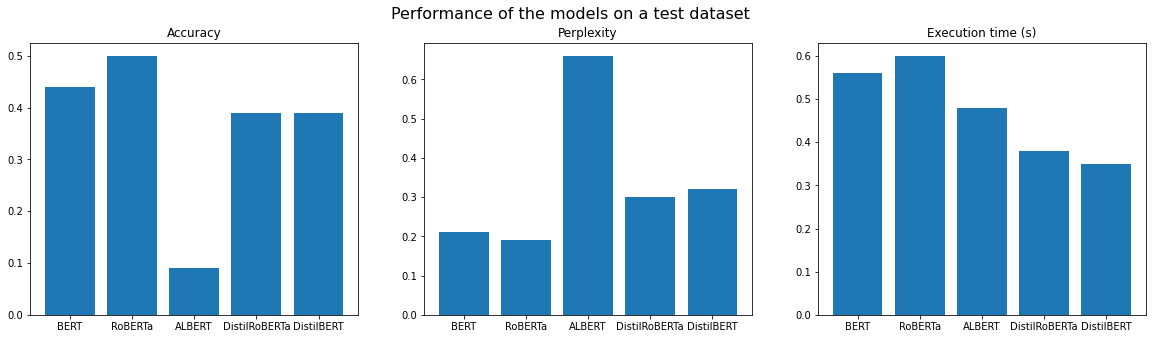

In [ ]:
accuracy = [0.44, 0.5, 0.09, 0.39, 0.39]
perplexity = [0.21, 0.19, 0.66, 0.3, 0.32]
execution_time = [0.56, 0.6, 0.48, 0.38, 0.35]

bins = ["BERT", "RoBERTa", "ALBERT", "DistilRoBERTa", "DistilBERT"]

# Visualize the accuracy, perplexity and execution time of each model in a bar chart all in the same plot

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].bar(bins, accuracy)
ax[0].set_title("Accuracy")
ax[1].bar(bins, perplexity)
ax[1].set_title("Perplexity")
ax[2].bar(bins, execution_time)
ax[2].set_title("Execution time (s)")

# add title
fig.suptitle("Performance of the models on a test dataset", fontsize=16)

plt.show()